<a href="https://colab.research.google.com/github/riddhikaa/csir_npl_work/blob/main/svm_and_knn_breast_Cancer_16384.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install category_encoders==2.6.0
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, svm, model_selection, tree, ensemble, neighbors, preprocessing, base, metrics
import category_encoders
import imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 2.6 MB/s eta 0:00:00


In [3]:
warnings.filterwarnings("ignore")

In [4]:
file_path = '/content/drive/MyDrive/breastcancer_data/original_Breast_GSE70947.xlsx'
df = pd.read_excel(file_path)

In [5]:
print(df.shape)

(289, 16384)


In [6]:
#selecting only 1000 features out of 16384
# selected_columns = df.columns[:4000]
# df_selected = df[selected_columns]
# df_selected.head()
df.head()

,samples,type,NM_144987,NM_013290,ENST00000322831,NM_001625,lincRNA:chr7:226042-232442_R,NM_032391,ENST00000238571,XR_108906,...,NM_207327,NM_001004477,NM_020700,NM_005895,NM_000679,NR_003529,NR_036446,NM_001001957,lincRNA:chr7:29652000-29661000_R,ENST00000494108
0,GSM1823702_252800417016_S01_GE1_107_Sep09_1_2,normal,8.693318,7.718016,6.044438,10.747077,9.133777,4.735581,5.634732,4.670231,...,10.453202,4.376090,5.597596,11.860087,11.321528,4.486530,5.489959,5.810069,4.834056,4.383929
1,GSM1823703_252800417016_S01_GE1_107_Sep09_2_1,normal,9.375980,7.072232,6.976741,10.429671,9.526500,5.221089,5.425187,4.860931,...,10.066372,4.383785,5.404546,11.636828,8.283747,4.770318,5.345571,4.457930,4.441395,4.411587
2,GSM1823704_252800416877_S01_GE1_107_Sep09_2_3,normal,8.943442,7.964573,6.269055,10.825025,9.396855,5.258506,5.824921,4.964604,...,10.380676,4.428892,5.356374,12.031338,9.420630,4.394069,5.851030,4.508072,4.568262,4.316081
3,GSM1823705_252800416894_S01_GE1_107_Sep09_1_1,normal,9.020798,7.824639,6.165165,11.646788,8.776462,4.648655,6.676692,4.770186,...,10.509871,4.381542,5.757179,11.944607,10.311339,4.451118,6.117379,4.505663,4.413361,4.537626
4,GSM1823706_252800416894_S01_GE1_107_Sep09_1_3,normal,8.806154,7.555348,6.230969,11.635247,8.911383,4.518054,6.520691,4.540453,...,10.552841,4.386116,6.851058,11.976510,10.904219,4.432566,6.286439,4.540453,4.412933,4.452250


In [7]:
df.head()
print(f"Total duplicates: {df.duplicated().sum()}") #checking for duplicates
#checking for null values
print(df.isna().sum())
print(f"Total null count: {df.isna().sum().sum()}")

Total duplicates: 0
samples                             0
type                                0
NM_144987                           0
NM_013290                           0
ENST00000322831                     0
                                   ..
NR_003529                           0
NR_036446                           0
NM_001001957                        0
lincRNA:chr7:29652000-29661000_R    0
ENST00000494108                     0
Length: 16384, dtype: int64
Total null count: 0


In [8]:
target = "type"
val_counts = df[target].value_counts()
print(val_counts, "\n\n")


type
normal                   146
breast_adenocarcinoma    143
Name: count, dtype: int64 




([<matplotlib.patches.Wedge at 0x7e4a9b0fb730>,
 [Text(-0.017935638819470537, 1.0998537688529952, 'normal'),
  Text(0.01793563881947016, -1.0998537688529952, 'breast_adenocarcinoma')],
 [Text(-0.0097830757197112, 0.5999202375561791, '50.52%'),
  Text(0.009783075719710994, -0.5999202375561791, '49.48%')])

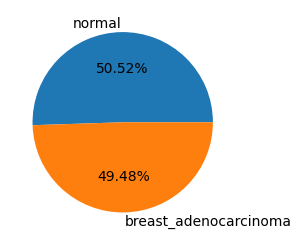

In [9]:
plt.subplot(1, 2, 2)
plt.pie(val_counts, labels = val_counts.keys(), autopct = "%.2f%%")

In [10]:
# Encoding categorical features (Ordinal Encoding)

class_map = {"normal": 0, "breast_adenocarcinoma": 1}
class_map_reverse = {m : n for m, n in zip(class_map.values(), class_map.keys())}

encoder = category_encoders.OrdinalEncoder(cols = [target], mapping = [{"col": target, "mapping": class_map}])
df['type'] = encoder.fit_transform(df[target])

In [11]:
X = df.drop(columns=df.columns[0]).values
y = df[target].values

print(X.shape, y.shape)
print(X)


(289, 16383) (289,)
[[0.         8.69331779 7.71801596 ... 5.81006943 4.83405623 4.38392868]
 [0.         9.37597965 7.07223164 ... 4.45792972 4.44139474 4.41158681]
 [0.         8.94344176 7.96457276 ... 4.50807186 4.56826205 4.31608095]
 ...
 [1.         9.0513847  7.65189288 ... 4.41435052 4.52880797 4.39442035]
 [1.         8.11460641 8.09668189 ... 6.15655541 4.38106974 4.44705215]
 [1.         8.82757478 7.53889842 ... 4.63430652 4.45075149 4.38308807]]


In [47]:
# Splitting the data into testing and training data (Stratified Splitting)
#split: 30% test and 70% train
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)
print(X_train.shape, X_test.shape)
X_train

(202, 16383) (87, 16383)


array([[0.        , 9.17559702, 8.01454138, ..., 4.50019441, 4.66437819,
        4.59171068],
       [0.        , 9.04047607, 7.84442778, ..., 5.57417421, 4.50513455,
        4.59957401],
       [0.        , 8.92586144, 7.49132906, ..., 4.39877603, 4.62753024,
        4.47436347],
       ...,
       [1.        , 8.32934381, 8.21710839, ..., 4.54886311, 4.50084753,
        4.4711697 ],
       [1.        , 8.66783834, 8.62899818, ..., 4.37979392, 4.50861855,
        4.35412715],
       [1.        , 8.74929057, 7.77024871, ..., 4.36613268, 4.48875225,
        4.47496393]])

In [48]:
# Feature Scaling (Z-Score Normalization)

scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_train = X_train_scaled.copy()
X_test = X_test_scaled.copy()

print(X_train[0].mean(), X_train[0].std())

0.09198344346193894 0.7968238583703432


Train Set:
0    102
1    100
Name: count, dtype: int64


Test Set:
0    44
1    43
Name: count, dtype: int64




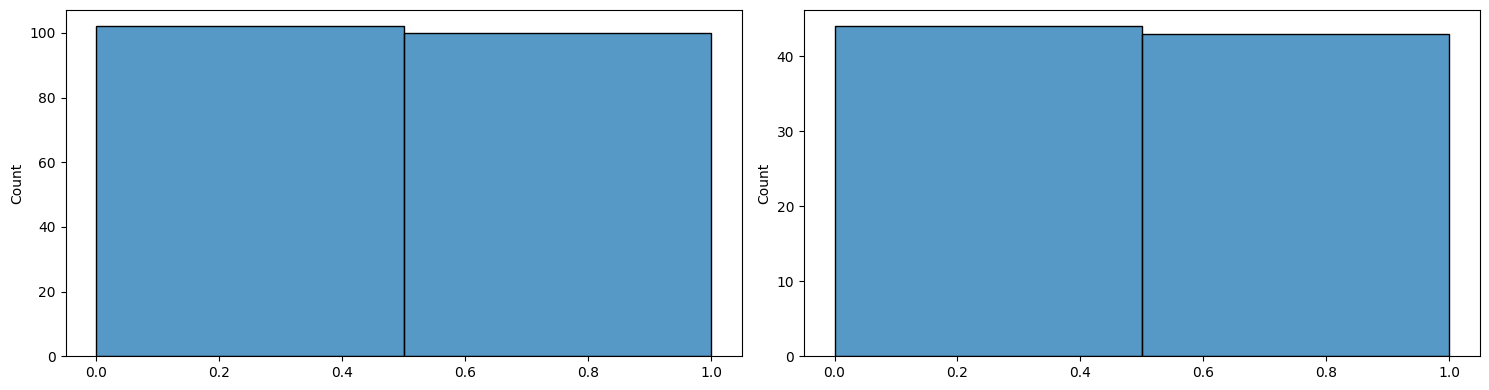

In [49]:
# Checking uniformity of labels across train and test data sets

print(f"Train Set:\n{pd.Series(y_train).value_counts()}\n\n")
print(f"Test Set:\n{pd.Series(y_test).value_counts()}\n\n")

plt.figure(figsize = (15, 4))

plt.subplot(1, 2, 1)
sns.histplot(y_train, bins = len(np.unique(y_train)))

plt.subplot(1, 2, 2)
sns.histplot(y_test, bins = len(np.unique(y_test)))

plt.tight_layout()
plt.show()

In [50]:
# Handling class imbalance through Synthetic Minority Over-sampling Technique (SMOTE)

smote = imblearn.over_sampling.SMOTE(random_state = 3, k_neighbors = 3)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(X_train_resampled.shape, y_train_resampled.shape)

(204, 16383) (204,)


In [51]:
X_train, y_train = X_train_resampled.copy(), y_train_resampled.copy()

In [67]:
# svm algo

from sklearn.svm import SVC
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

SVC(random_state=42)

In [68]:

print(svm_model.score(X_train, y_train))
print(svm_model.score(X_test, y_test))

0.9607843137254902
0.9195402298850575


Training Accuracy of SVM model: 0.96
Training F1 score of SVM model: 0.96
Testing Accuracy of SVM model: 0.92
Testing F1 score of SVM model: 0.91


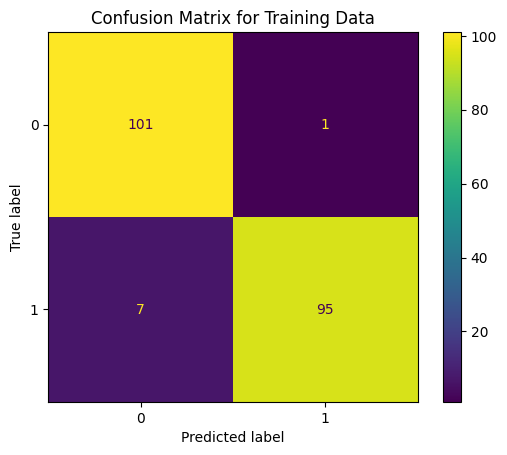

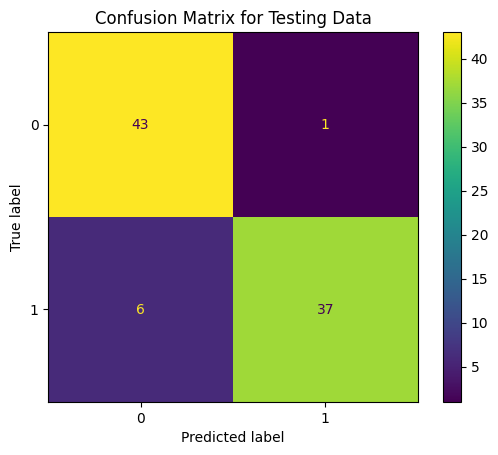

In [69]:
y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)

# Evaluation on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
print(f"Training Accuracy of SVM model: {train_accuracy:.2f}")
print(f"Training F1 score of SVM model: {train_f1:.2f}")

# Evaluation on testing data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
print(f"Testing Accuracy of SVM model: {test_accuracy:.2f}")
print(f"Testing F1 score of SVM model: {test_f1:.2f}")

# Confusion matrix for training data
train_cm = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(train_cm, display_labels=svm_model.classes_).plot()
plt.title('Confusion Matrix for Training Data')
plt.show()

# Confusion matrix for testing data
test_cm = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(test_cm, display_labels=svm_model.classes_).plot()
plt.title('Confusion Matrix for Testing Data')
plt.show()

Training Accuracy of KNN model: 0.89
Training F1 score of KNN model: 0.88
Testing Accuracy of KNN model: 0.80
Testing F1 score of KNN model: 0.78


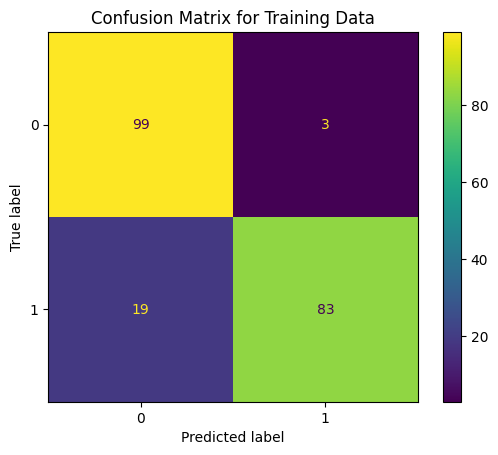

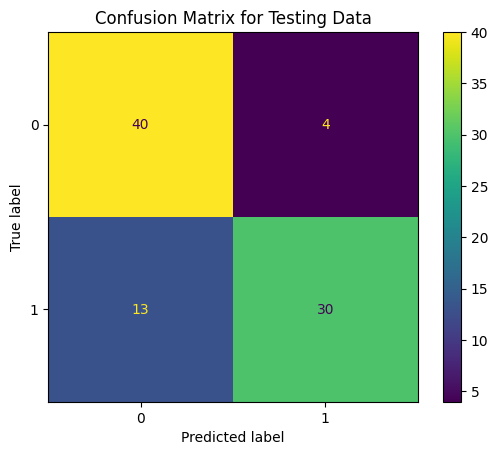

'\n80-20 split\nTraining Accuracy of KNN model: 0.91\nTraining F1 score of KNN model: 0.90\nTesting Accuracy of KNN model: 0.88\nTesting F1 score of KNN model: 0.87\n'

In [42]:
# knn algo

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


k = 3 #Number of neighbors
knn_model = KNeighborsClassifier(n_neighbors=k)

knn_model.fit(X_train, y_train)
y_train_pred = knn_model.predict(X_train) #training set
y_test_pred = knn_model.predict(X_test)#testing set

#Evaluating model performance on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
print(f"Training Accuracy of KNN model: {train_accuracy:.2f}")
print(f"Training F1 score of KNN model: {train_f1:.2f}")

#Evaluating model performance on testing data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
print(f"Testing Accuracy of KNN model: {test_accuracy:.2f}")
print(f"Testing F1 score of KNN model: {test_f1:.2f}")

#confusion matrix for training data
train_cm = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(train_cm, display_labels=knn_model.classes_).plot()
plt.title('Confusion Matrix for Training Data')
plt.show()

#confusion matrix for testing data
test_cm = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(test_cm, display_labels=knn_model.classes_).plot()

plt.title('Confusion Matrix for Testing Data')
plt.show()
'''
80-20 split
Training Accuracy of KNN model: 0.91
Training F1 score of KNN model: 0.90
Testing Accuracy of KNN model: 0.88
Testing F1 score of KNN model: 0.87
'''